# imports

In [118]:
%run read_matlab_file.ipynb
%run LC_calibration.ipynb

read_matlab_file.ipynb loaded successfully!
read_matlab_file.ipynb loaded successfully!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
read_matlab_file.ipynb loaded successfully!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


# XPEC data preperation

### TODO
    - Extract the bins from the txt file. DONE
    
    - Bin the keV into the predefined bins. DONE
    
    - Implement function for T0 & tus correction (ToF). DONE
        --> COMMENT: still 300ms error after calibrating GRB190206
        
    -Do all the steps above for GRB200415A and cross check results. DONE
    
    - Implement function for cutting the tus & keV array at time interval given by Anastasia or GCN report 
        ---> NEXT UP
 
    - make sure the T0 are correctly clibrated. Send complete list to Andrey for validation
    
    
### Notes
    -Assuming 
    -bins_keV are the right most edges! 
    -Anders have filtered for keV >=500 
    -Implementation is ok. Proceed to wrapping a function around it.
    --> have a shift variable as input (have to do with lining up the LC from the different spacecrafts)
    
    
### Problems
    -GRB200415: Problem lining up the T0 from my data to the data that Anders used to histogram the data for 0.8ms <=tus <= 3.2ms
    Since the data is shifted a small amount the number of counts in the bins don't match up correctly.
    --> Absolute time correction is neccecary, but this value might be different from the one Anders used.
    -->Error of 4151.099 ... us (4.1 ms) from df_A and my df.
 
    
    -GRB200415: The binning does not produce the same bin counts in Ander´s df_A and the df_check
    --> Because of filtering for keV's >= 500
    
    

In [2]:
#time of flight from KW to ASIM. Given in seconds
ToF = {"GRB180720":-4.2377,"GRB181222":2.8716, "GRB190206":4.9225, "GRB190305":3.4460,
      "GRB190606":4.0316,"GRB200415":4.1840,"GRB200521":-0.6226,"GRB200716":3.0155,
      "GRB201227":0.7142, "GRB210424":-0.5033, "GRB210619":-2.6183}

In [3]:
def ToF_correction(grb_id=None):
    ToF_us = ToF[grb_id]*1e6
    df,T0 = complete_df(grb_id=grb_id)
    df["tus"], T0_calibrated = df["tus"] - ToF_us, T0 - timedelta(microseconds=ToF_us) #calibrating 
    return df,T0,T0_calibrated

# bin control

In [6]:
df_bin = pd.read_csv("/Users/andreas/phys/master/GRB/spectral_analysis/HED_binedges.txt")
df_bin.head()

energy_bin_start_keV  energy_bin_stop_keV
0              10.00000             12.58925
1              12.58925             15.84893
2              15.84893             19.95262
3              19.95262             25.11886
4              25.11886             31.62278

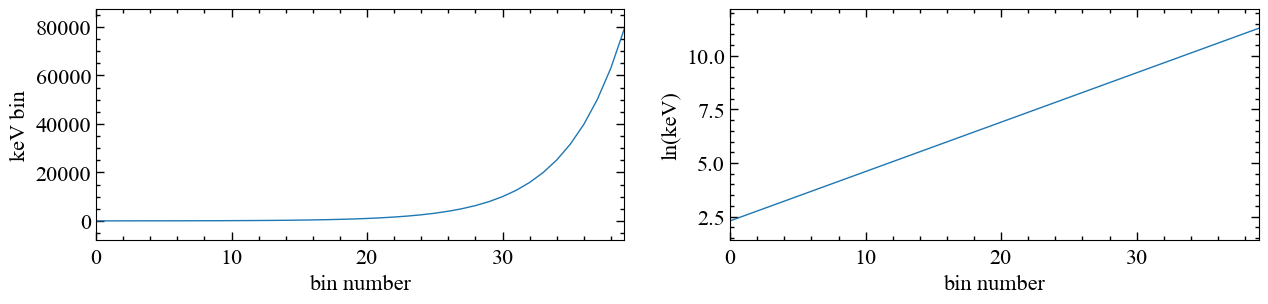

In [7]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,3))

ax1.plot((df_bin["energy_bin_start_keV"]))
ax2.plot(np.log(df_bin["energy_bin_start_keV"]))
ax1.set_xlabel("bin number")
ax1.set_ylabel("keV bin")
ax2.set_xlabel("bin number")
ax2.set_ylabel("ln(keV)")
plt.show()

In [17]:
start = df_bin["energy_bin_start_keV"].to_numpy()
#start = np.append(0,start)
end = df_bin["energy_bin_stop_keV"].to_numpy()
bins_keV=np.append(start,end[-1])
print(len(bins))
bins_keV

41


array([1.000000e+01, 1.258925e+01, 1.584893e+01, 1.995262e+01,
       2.511886e+01, 3.162278e+01, 3.981072e+01, 5.011872e+01,
       6.309573e+01, 7.943282e+01, 1.000000e+02, 1.258925e+02,
       1.584893e+02, 1.995262e+02, 2.511886e+02, 3.162278e+02,
       3.981072e+02, 5.011872e+02, 6.309573e+02, 7.943282e+02,
       1.000000e+03, 1.258925e+03, 1.584893e+03, 1.995262e+03,
       2.511886e+03, 3.162278e+03, 3.981072e+03, 5.011872e+03,
       6.309573e+03, 7.943282e+03, 1.000000e+04, 1.258925e+04,
       1.584893e+04, 1.995262e+04, 2.511886e+04, 3.162278e+04,
       3.981072e+04, 5.011872e+04, 6.309573e+04, 7.943282e+04,
       1.000000e+05])

In [9]:
df_hist_check = pd.read_csv("/Users/andreas/phys/master/GRB/spectral_analysis/HED_(0.8 ms to 3.2 ms).txt")
print("Num hist counts totoal: ", sum(df_hist_check["counts"].to_numpy()[1:]))
print("bins_keV are the right most edge")

df_hist_check.head()

Num hist counts totoal:  300.0
bins_keV are the right most edge


bins_keV  counts  poisson_error_counts  duration_seconds
0  10.00000 -9999.0               -9999.0        -9999.0000
1  12.58925     0.0                   0.0            0.0024
2  15.84893     0.0                   0.0            0.0024
3  19.95262     0.0                   0.0            0.0024
4  25.11886     0.0                   0.0            0.0024

# keV bin function

In [123]:
def keV_bin(df=None,time_interval=None,keV_interval=None,keV_bins=None):
    '''
    NOTE: working with ms resolution for the tus array
    
    input: df <pd.dataframe> complete dataframe with no flagged events
    time_interval <tuple> start and end (ms) of the time interval for the keV binning.
    keV_interval <tuple> default is None. Meaning the whole spectrum
    
    return: <pd.dataframe> with the bin_counts and bin_edges as a dataframe
    '''
    df.sort_values(by=['tus'],inplace=True) #first sorting by tus in increasing order
    
    
    #tus handling-------------------------------------------
    tus_arr = df["tus"].to_numpy()
    tus_arr = tus_arr/1e3 #converting to ms resolution

    
    if time_interval==None:
        tus_start,tus_end = min(tus_arr),max(tus_arr)
        idx_start, idx_end = find_nearest(tus_arr,tus_start), find_nearest(tus_arr,tus_end)+1 #including the last trigger
    else:
        tus_start,tus_end = time_interval[0],time_interval[1] #selecting the interval
        idx_start, idx_end = find_nearest(tus_arr,tus_start), find_nearest(tus_arr,tus_end)+1 #including the nearest trigger

    tus_arr = tus_arr[idx_start:idx_end] #selecting the interval for tus
    
    #keV handling-------------------------------------------
    keV_arr = df["keV"].to_numpy()
    keV_arr = keV_arr[idx_start:idx_end] #selecting keV's on the given tus interval
    
    if keV_interval==None:
         keV_lower,keV_upper = 0,1e16 #selecting artificially high bounds
    else: 
        keV_lower,keV_upper = keV_interval[0],keV_interval[1] #selecting the bounds for the keV's

    ii = []
    for i,keV in enumerate(keV_arr): #finding
        if keV_lower<=keV<=keV_upper:
            ii.append(i)
            
    tus_keV_bound = tus_arr[ii]
    keV_bound = keV_arr[ii]
    
    #histogramming-----------------------------------------
    hist_keV,edges_keV = np.histogram(keV_bound,bins=keV_bins)
    
    poisson_arr = np.sqrt(hist_keV) #handle this one. might be some negative numbers in it?
    if hist_keV[0] == 0:
        hist_keV = np.append(-9999,hist_keV)
        poisson_arr = np.append(-9999,poisson_arr)
        
    df_keV = pd.DataFrame({"keV right bin edge":edges_keV, "keV bin count":hist_keV, "Poission error":poisson_arr}) #ERROR different lengths!
    print("Energies binned!")
    return df_keV

In [130]:
(999670.5277777778-970399.8888888889)/1e3
#28.422 ms diff from complete vs df_A

29.270638888888875

In [132]:
df,T0 = complete_df(grb_id="GRB200415",remove_flag=True,lag=-29.270638888888875)
print(df["tus"].to_numpy()[0])
df_keV = keV_bin(df=df,time_interval=(0.8,3.2),keV_bins=bins_keV)
df_keV

Creating df for short GRB
Absolute time correction subtracted from T0
116 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 187 flags
Removed 187 flags from df
-999670.5277777778
Energies binned!


keV right bin edge  keV bin count  Poission error
0             10.00000          -9999    -9999.000000
1             12.58925              0        0.000000
2             15.84893              0        0.000000
3             19.95262              0        0.000000
4             25.11886              0        0.000000
5             31.62278              0        0.000000
6             39.81072              0        0.000000
7             50.11872              0        0.000000
8             63.09573              0        0.000000
9             79.43282              0        0.000000
10           100.00000              0        0.000000
11           125.89250              0        0.000000
12           158.48930              0        0.000000
13           199.52620              0        0.000000
14           251.18860              0        0.000000
15           316.22780             13        3.605551
16           398.10720             23        4.795832
17           501.18720             74        8.602325
18           630.95730             60        7.745967
19           794.32820             54        7.348469
20          1000.00000             36        6.000000
21          1258.92500             32        5.656854
22          1584.89300             25        5.000000
23          1995.26200             10        3.162278
24          2511.88600             13        3.605551
25          3162.27800              4        2.000000
26          3981.07200              5        2.236068
27          5011.87200              1        1.000000
28          6309.57300              1        1.000000
29          7943.28200              0        0.000000
30         10000.00000              1        1.000000
31         12589.25000              0        0.000000
32         15848.93000              0        0.000000
33         19952.62000              1        1.000000
34         25118.86000              2        1.414214
35         31622.78000              5        2.236068
36         39810.72000              3        1.732051
37         50118.72000              0        0.000000
38         63095.73000              0        0.000000
39         79432.82000              0        0.000000
40        100000.00000              0        0.000000